In [1]:
from platform import python_version
print(python_version())

3.12.4


The classical Rubik's cube is a 3D puzzle with about $4.3\times 10^{19}$ possible states. While this number is too large to use classical dynamic programming methods, the much smaller [Pocket Cube](https://en.wikipedia.org/wiki/Pocket_Cube) with its $3.7$[^1] million states still provide a rich problem space for exploration. This balance of reduced complexity and meaningful scale makes the Pocket Cube an excellent testing ground for evaluating and comparing tabular RL algorithms, offering insights into their ability to find the shortest path to the target state.

[^1]: $3674160$, to be precise (see, e.g., [@singmaster1981notes, p. 31])

## States and actions

We represent each **state** $s$ of the Pocket Cube by a permutation from $S_{24}$. The **solved** (**target**) state $s_0$ is the identity permutation. A **move** (or **action**) $a\in \mathcal A$ is a specific rotation of the cube which can also be written as such permutation. Making a move $a$ in state $s$ we arrive at new state $s'=a\circ s$. Usually we assume that $\mathcal A$ consists of clockwise and counterclockwise rotations of the front, right, and down faces: 

```{math}
:enumerated: false
\mathcal A = \{f, r, d, f^{-1}, r^{-1}, d^{-1}\},
```

where

```{math}
:enumerated: false
    f = (2\ 19\ 21\ 8) (3\ 17\ 20\ 10) (4\ 6\ 7\ 5) \\
    r = (1\ 5\ 21\ 14) (3\ 7\ 23\ 12) (8\ 10\ 11\ 9) \\
    d = (6\ 18\ 14\ 10) (7\ 19\ 15\ 11) (20\ 22\ 23\ 21)
```

See visualization (based on [this Kaggle notebook](https://www.kaggle.com/code/marksix/visualize-allowed-moves)) of move $f$ below.

```{figure} f0.svg
:alt: f0 move
:width: 100%
```

### Population counts of layers

The corresponding Cayley graph contains $3674160$ vertices of degree $\vert \mathcal A \vert = 6$. These vertices are naturally divided into disjoint layers $L_k = \{s \in G\colon \rho(s, s_0) = k\}$, $0\leqslant k \leqslant 14$, where $\rho(s, s_0)$ is the distance between states $s$ and $s_0$ in the Cayley graph. 

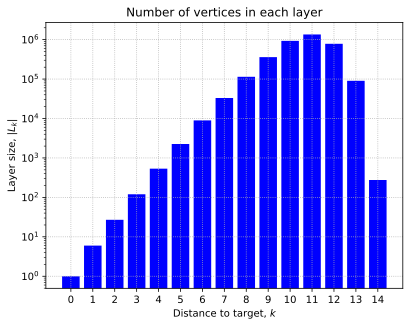

In [5]:
import numpy as np
import matplotlib.pyplot as plt

layers_pop = np.load("data/layers_pop.npy", allow_pickle=False)
plt.bar(np.arange(15), layers_pop, log=True, color='b')
plt.xticks(np.arange(15))
plt.title("Number of vertices in each layer")
plt.xlabel("Distance to target, $k$")
plt.ylabel(r"Layer size, $\vert L_k \vert$")
plt.grid(ls=":");
plt.show()

## Value iteration

Let $d(s)$ be the distance from state $s$ to the target state $s_0$:

$$
    d(s) = \rho(s, s_0) =  \min\limits_{\mathrm{path}(s_0, s)} |\mathrm{path}(s_0, s)|.
$$

Note that $d(s)$ satisfies the **Bellman equation**

$$
    d(s) = 1 + \min\limits_a d(a\circ s), \quad s \ne s_0, \quad d(s_0) = 0.
$$

To solve this equation we use DP:

* initialize $d_0(s)$ for all $s$ (e.g, by zeros)
* iteratively update 
    $$
    d_{n+1}(s) = \alpha(1 + \min\limits_a d_n(a\circ s)) + (1-\alpha)d_n(s), \quad 0 < \alpha \leqslant 1
    $$

Since we know the true distances $d(s)$ for $2\times 2 \times 2$ cube, we can easily check whether the process has converged or not: when $\|d_n(s) - d(s)\| < \varepsilon$, we are finished.

### Convergence study

We use different initializations $d_0(s)$:

* zero initialization $d_0(s) = 0$ for all $s$
* initialize each layer by a specific value (e.g., first $k$ layers by true distances, last $14 - k$ layers by zeros, $1 \leqslant k < 14$)
* **Manhattan** distance to the target:
  $$
      d_0(s) = \sum\limits_{k=0}^{23} \vert s_k - k \vert
  $$
* **Hamming** distance to the target:
  $$
      d_0(s) = \vert \{k\colon s_k \ne k\}\vert
  $$

For each $\alpha = \frac k{20}$, $1\leqslant k \leqslant 20$, run DP algorithm with different initialization strategies until convergence. On each iteration calculate correlation (Pearson or Spearman) between $d_i(s)$ and true distances $d(s)$.

It turns out that number of iterations mainly depends only on $\alpha$: the lower $\alpha$ is, the faster DP algorithm converges. For $\alpha = 1$ it converges in $14$ iterations for any type of initialization.

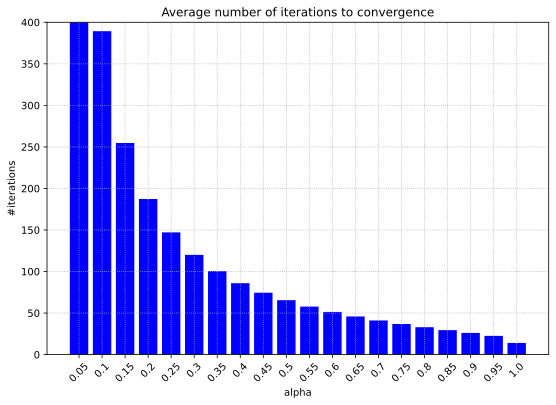

In [22]:
import json

with open("data/iterations.json") as f:
    iterations = json.load(f)

alphas = np.linspace(0.05, 1, num=20)
iteration_means = np.zeros(len(alphas))
for i in range(len(alphas)):
    for _, iters in iterations.items():
        iteration_means[i] += iters[i]

plt.figure(figsize=(9,6))
plt.bar(np.arange(len(alphas)), iteration_means / len(iterations), color='b')
plt.xticks(20*alphas - 1, [round(a, 2) for a in alphas], rotation=45)
plt.title("Average number of iterations to convergence")
plt.xlabel("alpha")
plt.ylabel("#iterations")
plt.ylim(0, 400)
plt.grid(ls=":")
plt.show()

In [20]:
import plotly.express as px
import plotly.graph_objects as go

init_names = (
            "all zeros",
            "1 true layer",
            "2 true layers",
            "3 true layers",
            "4 true layers",
            "5 true layers",
            "6 true layers",
            "7 true layers",
            "8 true layers",
            "9 true layers",
            "10 true layers",
            "11 true layers",
            "12 true layers",
            "13 true layers",
            "random walk",
            "random",
            "manhattan",
            "hamming",
            "catboost",
        )

pearson = np.load("data/pearson.npy", allow_pickle=False)

def plot_slider_correlations(alphas, eps=1e-8, write_html=False):
    fig = go.Figure()
    for i, alpha in enumerate(alphas):
        for j, init_type in enumerate(init_names):
            mask = pearson[j, i, :] <= 1.0 - eps
            fig.add_trace(
                go.Scatter(
                    x=np.arange(1, mask.shape[0] + 1),
                    y=pearson[j, i, mask],
                    name=init_type,
                    visible=False,
                    line=dict(color=px.colors.qualitative.Dark24[j], width=3)
                )
        )

    fig.update_layout(title={"text": r"Pearson correlation with target state", "x": 0.5},
                      xaxis_title=r"iteration",
                      yaxis_title=r"correlation",
                      margin=dict(t=50))

    visible_idx = len(alphas) - 1
    for i in range(len(init_names)):
        fig.data[i + visible_idx*len(init_names)].visible = True

    steps = []
    for i in range(len(alphas)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)}],  # layout attribute
            label=round(alphas[i], 2)
        )
        for j in range(len(init_names)):
            step["args"][0]["visible"][j + i*len(init_names)] = True 
        steps.append(step)

    sliders = [dict(
        active=visible_idx,
        pad={"t": 50},
        currentvalue={"prefix": "alpha ="}, 
        steps=steps
    )]
        
    fig.update_layout(
        sliders=sliders,
    )
    if write_html:
        fig.write_html("slider_pearson.html", full_html=False, include_plotlyjs='cdn', include_mathjax='cdn')
    # fig.show(renderer='iframe')
    fig.show()

In the next plot Pearson correlations between $d_i(s)$ and $d(s)$ versus iteration $i$ are shown. Note that for some initializations they are clearly not monotonic.

In [21]:
plot_slider_correlations(alphas, eps=0)

## Connection to RL

Suppose we are training an agent to solve Rubik's cube. After taking action $a$ in state $s$ the agent goes to state $s'$. If $s' \ne s_0$, the agent receives the reward $-1$, otherwise $0$:

$$
    r(s, a) = -[a \circ s = s_0]
$$

The goal is to maximize the total cumulative reward. This is the same as to find the shortest path from $s$ to $s_0$.

In RL the **value function** $v_*(s)$ is introduced which shows how good is state $s$. This function satisfies the **Bellman optimality equation**

$$
    v_*(s) = \max\limits_a \big\{r(s, a) + \gamma \mathbb E_{s'} v_*(s')\big\}.
$$

In our case $\gamma = 1$, $\mathbb E_{s'} v_*(s') = v_*(a\circ s)$ (environment is deterministic), hence

$$
    v_*(s) = \begin{cases}
        -1 + \max\limits_a \big\{v_*(a\circ s)\big\},& \forall a \; a\circ s \ne s_0, \\
         0, & \exists a\; a\circ s = s_0
    \end{cases}
$$

(assume $v_*(s_0) = 0$). Now it's clear that

$$
    v_*(s) = - d(s).
$$

### Bellman expectation

To evaluate a policy $\pi(a\vert s)$ one can use **Bellman expectation equality**:

$$
    v_\pi(s) = \mathbb E_{a \sim \pi(a\vert s)} \big\{r(s, a) + \gamma \mathbb E_{s'} v_\pi(s')\big\}.
$$

For uniformly random policy we have

$$
    \mathbb E_{a \sim \pi(a\vert s)} r(s, a) = -1 \text{ if } \forall a \in \mathcal A \;\;a \circ s \ne s_0, \quad \mathbb E_{a \sim \pi(a\vert s)} r(s, a) = -\frac 56 \text{ otherwise}.
$$

Our environment is deterministic, hence, $\mathbb E_{s} v_\pi(s) = v_\pi(s)$ for all $s \in \mathcal S$. Finally, we obtain the following linear system:

$$
    v_\pi(s) = -\frac 1{\vert\mathcal A\vert}\sum\limits_{a \in \mathcal A}[a\circ s = s_0] + \frac{\gamma}{\vert \mathcal A \vert} \sum\limits_{a \in \mathcal A} v_\pi(a \circ s).
$$

Now solve this system for $\vert \mathcal A \vert = 6$:

See a lot of huge numbers in each layer:

## TODO

* Furhter research of convergence of DP
* Apply **Bellman expectation equality** to random policy (aka random walks)
* Investigate RL approaches from [DeepCube](https://deepcube.igb.uci.edu/static/files/SolvingTheRubiksCubeWithDeepReinforcementLearningAndSearch_Final.pdf) and [AlphaCube](https://github.com/kyo-takano/alphacube)
* Try DQN and other NN methods to $3\times 3 \times 3$ (or larger) cube